In [71]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec            # to arrange the plots nicely
import pandas as pd
import math
from scipy.optimize import curve_fit

%matplotlib inline
plt.style.use('tableau-colorblind10')

In [5]:
#=====================================
# Load txt file to pandas dataframe
#=====================================
data_raw = pd.read_csv('mu-g4.txt', sep='\t', names=['tdc11', 'tdc12', 'tdc13', 'tdc14', 'tdc15', 'tdc16', 'tdc17', 'tdc18',
                                                        'tdc21', 'tdc22', 'tdc23', 'tdc24', 'tdc25', 'tdc26', 'tdc27', 'tdc28',
                                                       ])
data_raw = data_raw.rename(columns={'tdc11' : 'p0_1',
                            'tdc12' : 'p1_1',
                            'tdc13' : 'p2_1',
                            'tdc14' : 'start2',
                            'tdc24' : 'p0_2',
                            'tdc25' : 'p1_2',
                            'tdc26' : 'p2_2',
                            'tdc23' : 'stop2',
                           })
print('Total number of events:', len(data_raw))
#data_raw.head()

Total number of events: 1014917


In [6]:
# keeps only necessary

data = data_raw[['p0_1','p1_1','p2_1','start2','p0_2','p1_2','p2_2','stop2']]
#data.head()

In [7]:
# loads fitted parameters from parameters.txt

par=pd.read_csv('parameters.txt', sep=' ', names=['tdc','a','b'])
df_par=par.set_index('tdc')
#df_par.head()

In [8]:
#=====================================
# Convert tdc units into ns
#=====================================
def tdc_to_ns(channel, tdc_unit):
    ns = (tdc_unit - df_par.loc[channel, 'b']) / df_par.loc[channel, 'a']
    return ns

#=====================================
# Only one valide time for each detector
#=====================================
def merge_time(d,number):
    if (d['p%i_1'%(number)]==4095):
        return d['p%i_2_ns'%(number)]
    else:
        return d['p%i_1_ns'%(number)]
    
#=====================================
# Add actual time variables to the dataframe
#=====================================
def conv_time(d):
    d['start2_ns'] = tdc_to_ns('tdc14', d.start2)
    d['p0_1_ns'] = tdc_to_ns('tdc11', d.p0_1)
    d['p1_1_ns'] = tdc_to_ns('tdc12', d.p1_1)
    d['p2_1_ns'] = tdc_to_ns('tdc13', d.p2_1)
    d['p0_2_ns'] = tdc_to_ns('tdc24', d.p0_2) + d.start2
    d['p1_2_ns'] = tdc_to_ns('tdc25', d.p1_2) + d.start2
    d['p2_2_ns'] = tdc_to_ns('tdc26', d.p2_2) + d.start2
    
    d['p0_time'] = d.apply(lambda d: merge_time(d,0),axis=1)
    d['p1_time'] = d.apply(lambda d: merge_time(d,1),axis=1)
    d['p2_time'] = d.apply(lambda d: merge_time(d,2),axis=1)
    return d

In [9]:
#=====================================
# Data selection cuts
#=====================================

# eventi sui singoli piani
def cut_p0(data):
    cut = ((data.p0_1!=4095) | (data.p0_2!=4095)) & ((data.p1_1==4095) & (data.p1_2==4095)  & (data.p2_1==4095) & (data.p2_2==4095))
    p0 = data[cut]
    #p0 = p0.rename(columns={'p0_1': 'time_tdc1', 'p0_2': 'time_tdc2'})
    #p0 = p0[['tdc1','tdc2']]
    return p0

def cut_p1(data):
    cut = ((data.p1_1!=4095) | (data.p1_2!=4095)) & ((data.p0_1==4095) & (data.p0_2==4095)  & (data.p2_1==4095) & (data.p2_2==4095))
    p1 = data[cut]
    #p1 = p1.rename(columns={'p1_1': 'time_tdc1', 'p1_2': 'time_tdc2'})
    #p1 = p1[['tdc1','tdc2']]
    return p1

def cut_p2(data):
    cut = ((data.p2_1!=4095) | (data.p2_2!=4095)) & ((data.p1_1==4095) & (data.p1_2==4095)  & (data.p0_1==4095) & (data.p0_2==4095))
    p2 = data[cut]
    #p2 = p2.rename(columns={'p2_1': 'time_tdc1', 'p2_2': 'time_tdc2'})
    #p2 = p2[['tdc1','tdc2']]
    return p2

# buoni

def soft_cut(d):
    p_ms = d[((d.p1_1!=4095) | (d.p1_2!=4095)) & (d.p2_1==4095) & (d.p2_2==4095)]
    p_ms1 = p_ms['p1_time'][(p_ms.p0_1==4095) & (p_ms.p0_2==4095)]
    p_ms1 = p_ms1.rename(columns={'p1_time':'time'})
    p_ms0 = p_ms['p0_time'][(p_ms.p1_1!=4095) & (p_ms.p1_2!=4095)]
    p_ms0 = p_ms0.rename(columns={'p0_time':'time'})
    p2 = cut_p2(d)
    p2 = p2['p2_time']
    p2 = p2.rename(columns={'p2_time':'time'})
    p_me = pd.concat([p_ms1,p_ms0,p2])
    return p_me

def hard_cut(d):
    p_ms = d[((d.p1_1!=4095) | (d.p1_2!=4095)) & (d.p2_1==4095) & (d.p2_2==4095)]
    p_ms1 = p_ms['p1_time'][(p_ms.p0_1==4095) & (p_ms.p0_2==4095)]
    p_ms1 = p_ms1.rename(columns={'p1_time':'time'})
    p_ms0 = p_ms['p0_time'][(p_ms.p1_1!=4095) & (p_ms.p1_2!=4095) & (p_ms.p1_time<p_ms.p0_time)]
    p_ms0 = p_ms0.rename(columns={'p0_time':'time'})
    p2 = cut_p2(d)
    p2 = p2['p2_time']
    p2 = p2.rename(columns={'p2_time':'time'})
    p_me = pd.concat([p_ms1,p_ms0,p2])
    return p_me


In [10]:
#=====================================
# Functions to fit
#=====================================

def simple_expo (x, c, tau, d):
    return c*np.exp(-x/tau)+d

In [11]:
#=====================================
# Apply first selection and add time variables to main dataframe
#=====================================

data_used = data[(data.p0_1!=4095) | (data.p0_2!=4095) | (data.p1_1!=4095) | (data.p1_2!=4095) | (data.p2_1!=4095) | (data.p2_2!=4095)]
data_used = conv_time(data_used)
print('Total numer of triggers:', len(data))
print('Total numer of valid events:', len(data_used))
#data_used.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

Total numer of triggers: 1014917
Total numer of valid events: 14976


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


P0 events: 526
[ 38.57825026 177.06959366   4.47237979]
[[ 2.48855467e+01 -1.17429469e+02  4.38308449e-02]
 [-1.17429469e+02  9.75942102e+02 -2.18906769e+00]
 [ 4.38308449e-02 -2.18906769e+00  1.07751229e-01]]


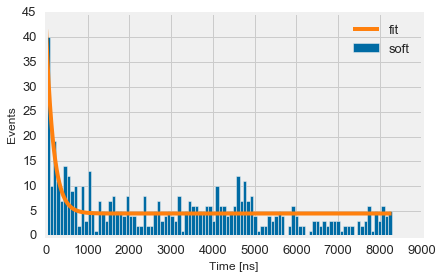

In [72]:
# esegue taglio piano 0 
p0 = cut_p0(data_used)
p0 = p0['p0_time']
print('P0 events:', len(p0))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p0, bins=100, label='soft')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(simple_expo, bin_centers, bin_heights, p0=[500.,2000.,2.])
print(popt)
print(pcov)

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='fit')
plt.legend()
plt.show()

P1 events: 11732
[372.87817775 922.82432077  -2.13492069]
[[ 3.54612991e+02 -8.87253717e+02  1.01531146e+00]
 [-8.87253717e+02  5.91187328e+03 -1.69955030e+02]
 [ 1.01531146e+00 -1.69955030e+02  1.69402627e+01]]


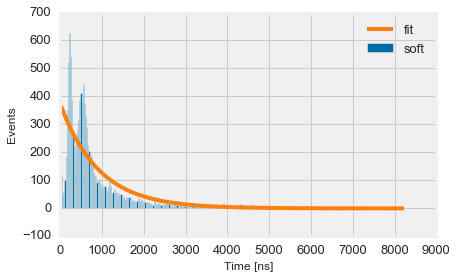

In [75]:
# esegue taglio piano 1
p1 = cut_p1(data_used)
p1 = p1['p1_time']
print('P1 events:', len(p1))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p1, bins=300, label='soft')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(simple_expo, bin_centers, bin_heights, p0=[500.,2000.,2.])
print(popt)
print(pcov)

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='fit')
plt.legend()
plt.show()

P2 events: 1579
[ 66.9809958  899.34295979   8.655084  ]
[[ 2.44107771e+01 -3.32453908e+02  8.26438007e-02]
 [-3.32453908e+02  1.17235809e+04 -5.92011553e+01]
 [ 8.26438007e-02 -5.92011553e+01  1.08240579e+00]]


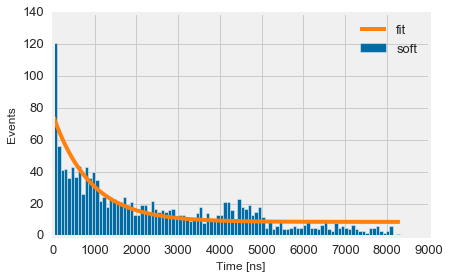

In [74]:
# esegue taglio piano 2
p2 = cut_p2(data_used)
p2 = p2['p2_time']
print('P2 events:', len(p2))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p2, bins=100, label='soft')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(simple_expo, bin_centers, bin_heights, p0=[500.,2000.,2.])
print(popt)
print(pcov)

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='fit')
plt.legend()
plt.show()

Events: 13399
[ 4.08567255e+02  9.80000000e+02 -6.32669625e-01]
[[ 3.64837518e+02 -8.84278441e+02  9.83766609e-01]
 [-8.84278441e+02  5.72973080e+03 -1.70422715e+02]
 [ 9.83766609e-01 -1.70422715e+02  1.75415815e+01]]


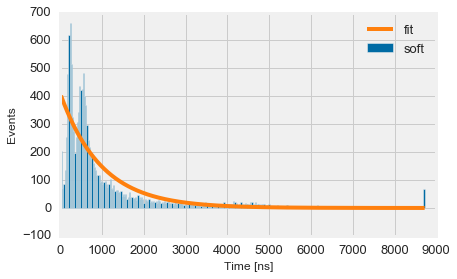

In [76]:
# esegue taglio: taglio soft
p_merged = soft_cut(data_used)

#print('Events used:', len(p_ms))
print('Events:', len(p_merged))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p_merged, bins=300, label='soft')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(simple_expo, bin_centers, bin_heights, p0=[1500.,1000.,8.], bounds=([-np.inf,980.,-np.inf],[np.inf,2500.,np.inf]))
print(popt)
print(pcov)

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='fit')
plt.legend()
plt.show()

Events: 2135
[ 132.26790554 2249.01839485    2.56311805]
[[ 2.39205941e+02 -4.51267451e+03  2.89792210e+01]
 [-4.51267451e+03  9.86473146e+04 -7.35233607e+02]
 [ 2.89792210e+01 -7.35233607e+02  6.53721990e+00]]


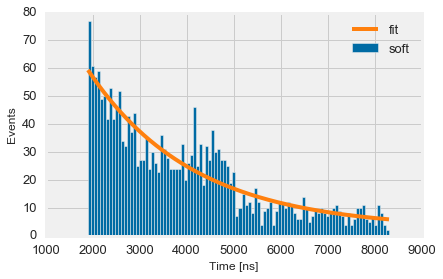

In [77]:
# esegue taglio: taglio soft CON CAMBIO DI RANGE
p_merged = soft_cut(data_used)
p_merged=p_merged[(p_merged>1900)&(p_merged<8500)]

#print('Events used:', len(p_ms))
print('Events:', len(p_merged))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p_merged, bins=100, label='soft')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(simple_expo, bin_centers, bin_heights, p0=[1500.,2000.,8.])
print(popt)
print(pcov)

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='fit')
plt.legend()
plt.show()

In [54]:
np.sqrt(9.86473146e+04)

314.08170051755644

Events: 13394
[1259.21970484  915.54567454    3.68997009]
[[ 9394.53858841 -6919.59262973    28.21387419]
 [-6919.59262973 13085.62893529 -1175.40824499]
 [   28.21387419 -1175.40824499   397.25931189]]


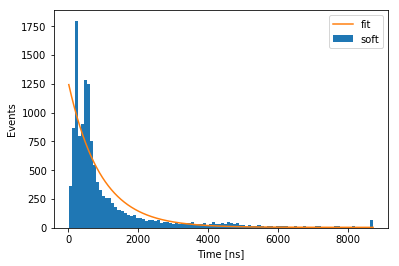

In [155]:
# esegue taglio: hard
p_merged = hard_cut(data_used)

#print('Events used:', len(p_ms))
print('Events:', len(p_merged))

# istogramma taglio
bin_heights, bin_borders, _ = plt.hist(p_merged, bins=100, label='soft')
bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
plt.xlabel('Time [ns]')
plt.ylabel('Events')

# fit
popt, pcov = curve_fit(simple_expo, bin_centers, bin_heights, p0=[1800.,1000.,2.])
print(popt)
print(pcov)

# grafico
x_interval_for_fit = np.linspace(bin_borders[0], bin_borders[-1], 10000)
plt.plot(x_interval_for_fit, simple_expo(x_interval_for_fit, *popt), label='fit')
plt.legend()
plt.show()


In [3]:
matplotlib.get_configdir()

'/Users/massimilianogalli/.matplotlib'